In [1]:
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install neurokit2
import neurokit2 as nk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 3.5 MB/s eta 0:00:00a 0:00:01


LOADING DATA

In [3]:
subject = 15

In [4]:
BASE = '/kaggle/input/ppg-dalia-dataset/PPG_FieldStudy'   
pkl_path = os.path.join(BASE, f"S{subject}", f"S{subject}.pkl")
with open(pkl_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')
#data

DATA SUMMERY

In [5]:
summary = []

for device in data['signal']:
    for sensor in data['signal'][device]:
        dt = data['signal'][device][sensor].flatten()
        summary.append({
            'device': device,
            'sensor': sensor,
            'min': dt.min(),
            'max': dt.max(),
            'mean': dt.mean(),
            'median': np.median(dt)
        })
df_summary = pd.DataFrame(summary)
from IPython.display import display
display(df_summary)

,device,sensor,min,max,mean,median
0,chest,ACC,-4.165200,4.496800,0.263912,0.060600
1,chest,ECG,-1.500000,1.499954,0.002157,-0.036392
2,chest,EMG,-1.500000,-1.500000,-1.500000,-1.500000
3,chest,EDA,0.000000,0.000000,0.000000,0.000000
4,chest,Temp,-273.149994,-273.149994,-273.149963,-273.149994
5,chest,Resp,-24.043274,21.783447,0.049764,-0.151062
6,wrist,ACC,-2.000000,1.984375,-0.122420,-0.125000
7,wrist,BVP,-966.820000,831.840000,0.000417,2.110000
8,wrist,EDA,0.142460,7.489662,2.996462,2.838980
9,wrist,TEMP,30.050000,34.430000,32.533825,33.630000


sampling frequancy

In [6]:
#SAMPLING FREQUANCIES OF SENSORS
eda_freq = 4
resp_freq = 700
temp_freq = 4
acc_chest_freq = 700
acc_wrist_freq = 32
activity_freq = 4

eda_signal = data['signal']['wrist']['EDA']
resp_signal = data['signal']['chest']['Resp']
temp_signal = data['signal']['wrist']['TEMP']
acc_chest_signal = data['signal']['chest']['ACC']
acc_wrist_signal = data['signal']['wrist']['ACC']
activity_signal = data['activity']

In [7]:
l_activity = len(activity_signal)
l_eda = len(eda_signal)
l_resp = len(resp_signal) 
l_temp = len(temp_signal)
l_acc_chest = len(acc_chest_signal)
l_acc_wrist = len(acc_wrist_signal)


print("activity", l_activity ,"sampling freq:", activity_freq ,"recording time:", l_activity / activity_freq )
print("eda", l_eda ,"sampling freq:", eda_freq ,"recording time:", l_eda / eda_freq )
print("resp", l_resp ,"sampling freq:", resp_freq ,"recording time:", l_resp / resp_freq )
print("temp", l_temp ,"sampling freq:", temp_freq ,"recording time:", l_temp / temp_freq )
print("chest-acc", l_acc_chest,"sampling freq:", acc_chest_freq ,"recording time:", l_acc_chest / acc_chest_freq)
print("wrist_acc", l_acc_wrist,"sampling freq:", acc_wrist_freq ,"recording time:", l_acc_wrist / acc_wrist_freq)

print("###")
print("ecg" , len(data['signal']['chest']['ECG']))

activity 31756 sampling freq: 4 recording time: 7939.0
eda 31756 sampling freq: 4 recording time: 7939.0
resp 5557300 sampling freq: 700 recording time: 7939.0
temp 31756 sampling freq: 4 recording time: 7939.0
chest-acc 5557300 sampling freq: 700 recording time: 7939.0
wrist_acc 254048 sampling freq: 32 recording time: 7939.0
###
ecg 5557300


In [8]:
end_time = l_activity / 4
l_activity 

31756

ACTIVITY

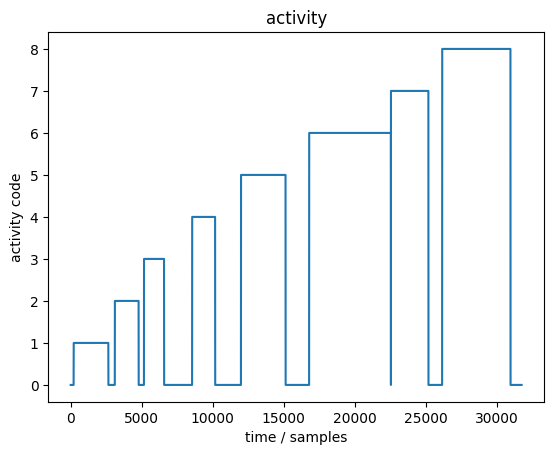

In [9]:
plt.plot(data['activity'])
plt.title("activity")
plt.xlabel("time / samples")
plt.ylabel("activity code")
plt.show()

In [10]:
activity_final = np.array(activity_signal.flatten())
activity_final

array([0., 0., 0., ..., 0., 0., 0.])

ELECTRODERMAL ACTIVITY SIGNAL 

HEART RATE

In [11]:
import numpy as np
from scipy.interpolate import interp1d

def full_resolution_hr(r_peaks, fs=700, signal_len=None, win_sec=8, step_sec=2):
    win_size = int(win_sec * fs)
    step_size = int(step_sec * fs)
    signal_len = signal_len or r_peaks[-1]

    times, hr = [], []

    for start in range(0, signal_len - win_size + 1, step_size):
        end = start + win_size
        r_win = r_peaks[(r_peaks >= start) & (r_peaks < end)]

        if len(r_win) >= 2:
            rr = np.diff(r_win) / fs
            bpm = 60 / rr
            hr.append(np.mean(bpm))
        else:
            hr.append(np.nan)

        times.append((start + end) / 2 / fs)

    times = np.array(times)
    hr = np.array(hr)

    valid = ~np.isnan(hr)
    if np.sum(valid) < 2:
        raise ValueError("Not enough valid heart rate points to interpolate.")

    interp_fn = interp1d(times[valid], hr[valid], kind='linear', fill_value='extrapolate')

    total_samples = signal_len if isinstance(signal_len, int) else len(signal_len)
    time_axis = np.arange(total_samples) / fs
    hr_per_sample = interp_fn(time_axis)

    return hr_per_sample



In [12]:
data['rpeaks']

array([    506,    1267,    2097, ..., 5556187, 5556712, 5557262],
      dtype=int32)

In [13]:
hr_signal = full_resolution_hr(data['rpeaks'], fs=700, signal_len = 6448400)

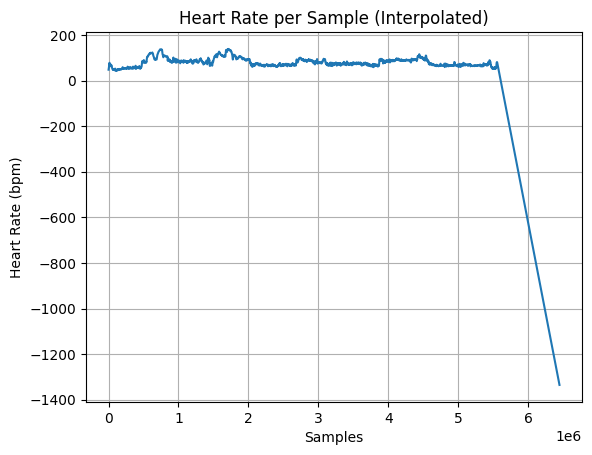

In [14]:
plt.plot(hr_signal)
plt.xlabel("Samples")
plt.ylabel("Heart Rate (bpm)")
plt.title("Heart Rate per Sample (Interpolated)")
plt.grid(True)
plt.show()

In [15]:
hr_final = np.array(hr_signal)

In [16]:
hr_final

array([   47.45756929,    47.4591165 ,    47.46066372, ...,
       -1334.98521264, -1334.98680022, -1334.98838779])

RESPIRATORY SIGNAL 

RAW DATA

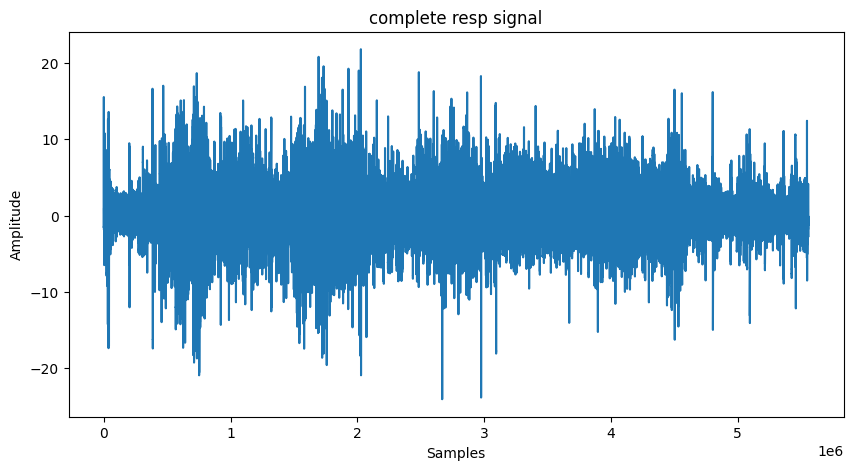

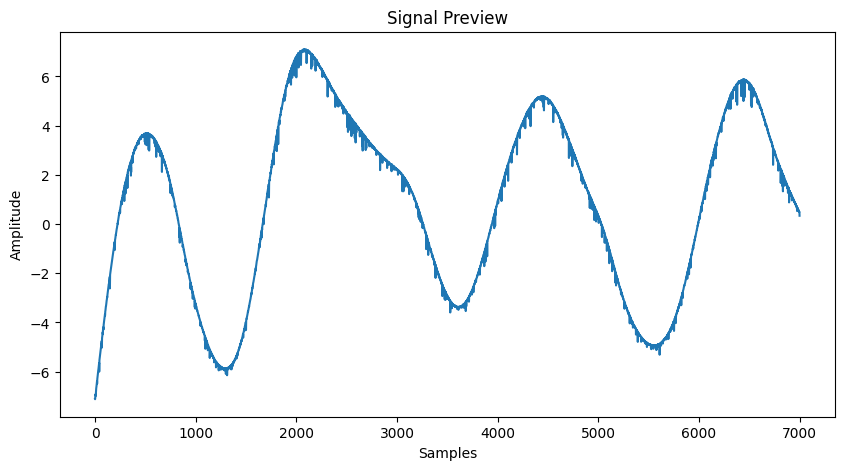

In [17]:
preview_start = 2900
preview_end = 2910

start = preview_start * resp_freq 
end = preview_end * resp_freq


signal = resp_signal.flatten()

plt.figure(figsize=(10, 5))
plt.plot(signal[:]) 
plt.title('complete resp signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(signal[start:end ]) 
plt.title('Signal Preview')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

CLEAN DATA 

<Axes: >

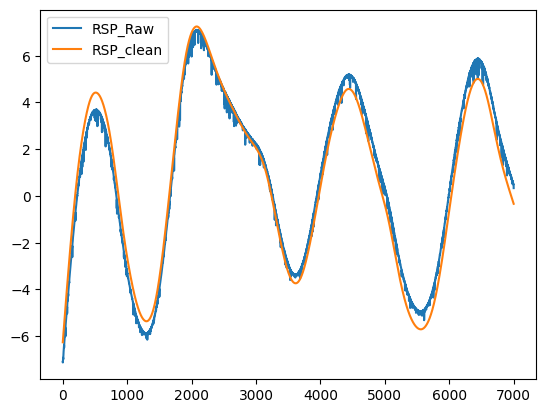

In [18]:
rsp_clean = nk.rsp_clean(resp_signal, sampling_rate=resp_freq).flatten()

signals = pd.DataFrame({
    "RSP_Raw": signal[start:end],
    "RSP_clean":rsp_clean[start:end],
})
signals.plot()

CLEAN DATA OVERVIEW

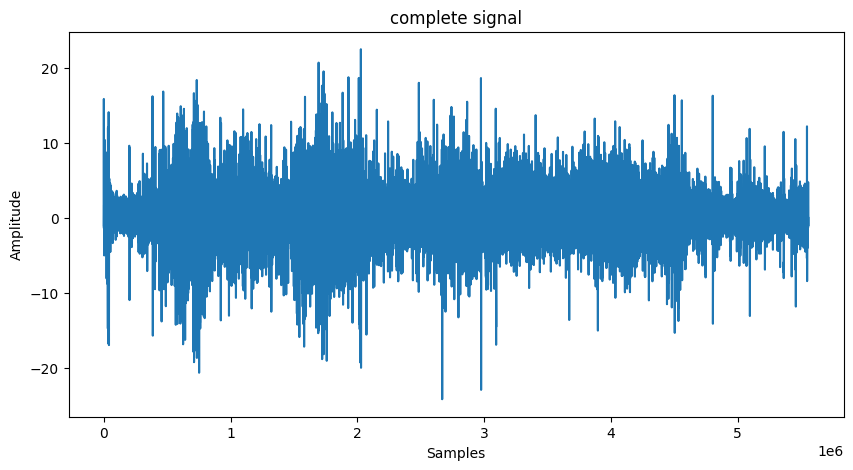

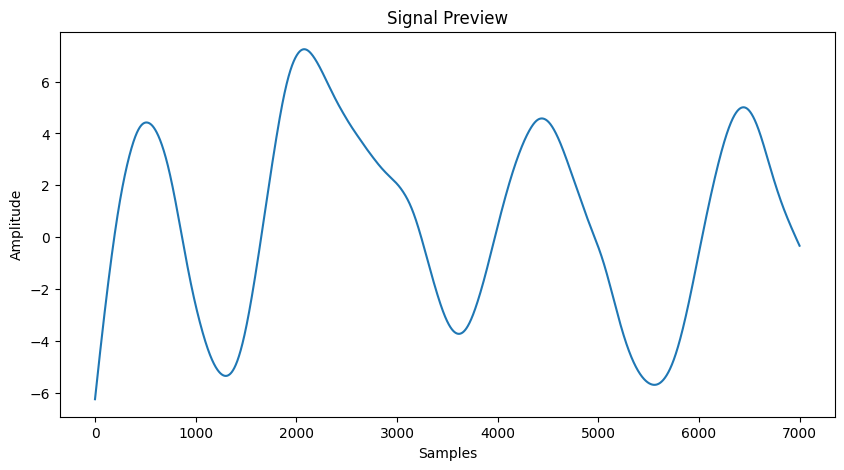

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(rsp_clean[:]) 
plt.title('complete signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(rsp_clean[start:end ]) 
plt.title('Signal Preview')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

view whole data in chunks!

In [20]:
"""
chunk_size = 300 * resp_freq
for i in range(0, len(signal), chunk_size):
    plt.figure(figsize=(15, 4))
    plt.plot(signal[i:i+chunk_size])
    plt.title(f'Data from {i/resp_freq} to {(i+chunk_size)/resp_freq}')
    plt.show()
"""

"\nchunk_size = 300 * resp_freq\nfor i in range(0, len(signal), chunk_size):\n    plt.figure(figsize=(15, 4))\n    plt.plot(signal[i:i+chunk_size])\n    plt.title(f'Data from {i/resp_freq} to {(i+chunk_size)/resp_freq}')\n    plt.show()\n"

5 SECOND MOVING AVRAGE ON RATE OF RESP SIGNAL

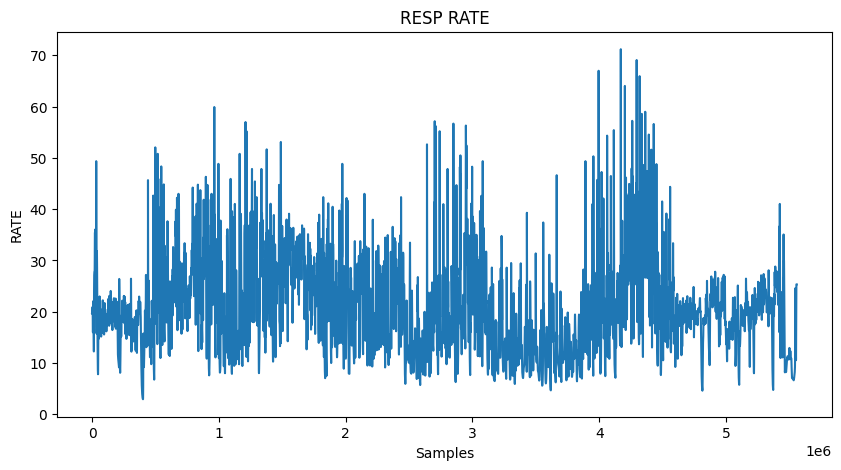

In [21]:
rsp_rate_onsets = nk.rsp_rate(rsp_clean, sampling_rate=resp_freq, method="trough")
plt.figure(figsize = (10,5))
plt.plot(rsp_rate_onsets[:]) 
plt.title('RESP RATE')
plt.xlabel('Samples')
plt.ylabel('RATE')
plt.show()

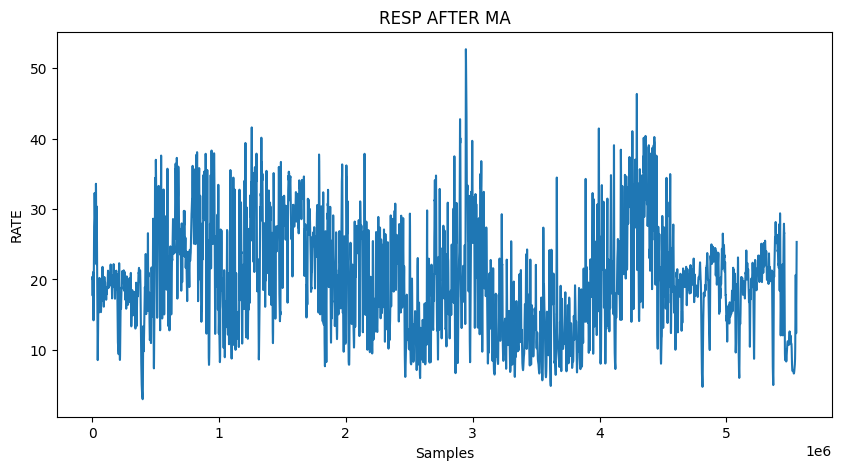

In [22]:
 #moving avrage set on 5 sec windows
window = 5 
rsp_avg = pd.Series(rsp_rate_onsets.flatten()).rolling(window * resp_freq).mean().dropna().reset_index(drop=True)
plt.figure(figsize = (10,5))
plt.plot(rsp_avg[:]) 
plt.title('RESP AFTER MA')
plt.xlabel('Samples')
plt.ylabel('RATE')
plt.show()

In [23]:
resp_final = np.array(rsp_avg)
resp_final

array([20.13708761, 20.13745558, 20.13782355, ..., 25.33172497,
       25.33172497, 25.33172497])

TEMPRETURE SIGNAL

In [24]:
preview_start = 2900
preview_end = 2910

start = preview_start * temp_freq 
end = preview_end * temp_freq

TEMPRETURE OVERVIEW

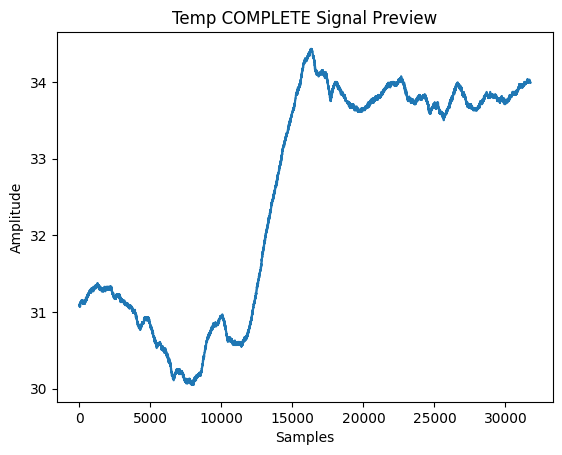

In [25]:
plt.plot(temp_signal[:]) 
plt.title('Temp COMPLETE Signal Preview')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

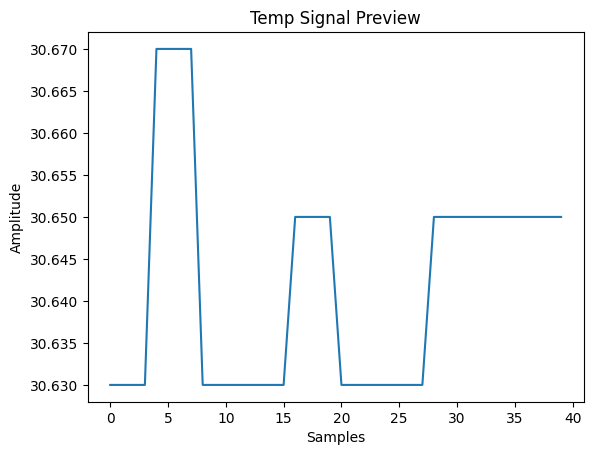

In [26]:
plt.plot(temp_signal[start:end]) 
plt.title('Temp Signal Preview')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

MOVING AVRAGE 

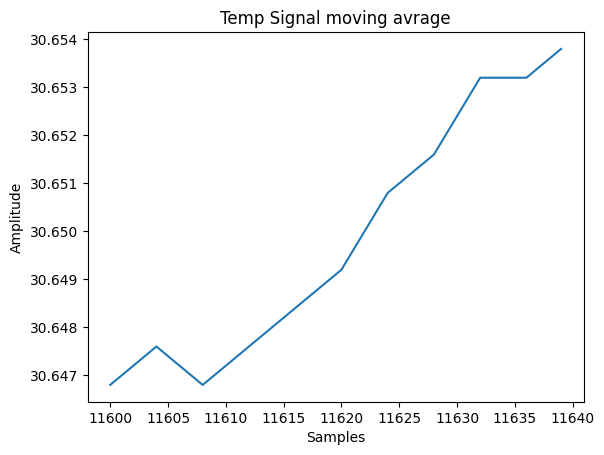

In [27]:
Temp_signal_1d = temp_signal.flatten() 
window = 25
temp_avg = pd.Series(Temp_signal_1d).rolling(temp_freq * window).mean().dropna().reset_index(drop=True)


plt.plot(temp_avg[start:end]) 
plt.title('Temp Signal moving avrage')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

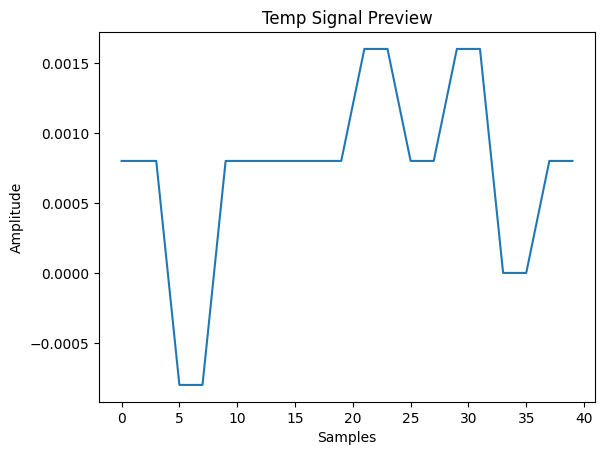

In [28]:
dt = 1/4
slope = np.gradient(temp_avg.values, dt)
plt.plot(slope[start:end]) 
plt.title('Temp Signal Preview')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

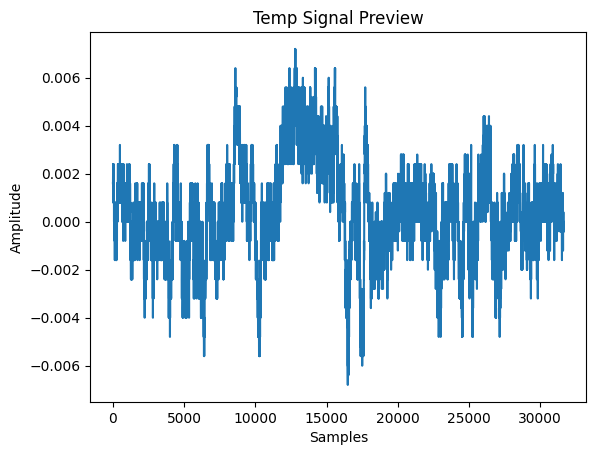

In [29]:
plt.plot(slope[:]) 
plt.title('Temp Signal Preview')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

In [30]:
temp_avg_final = np.array(temp_avg)
temp_grad_final = np.array(slope)

CHEST AND WRIST ACC

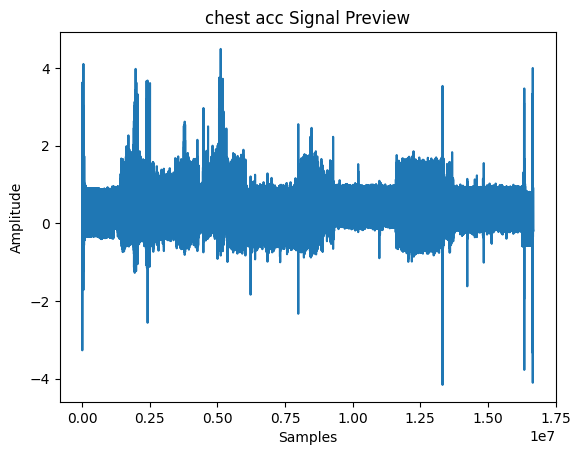

In [31]:
signal = acc_chest_signal.flatten()  

plt.plot(signal[:]) 
plt.title('chest acc Signal Preview')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

eucl norm and moving average 

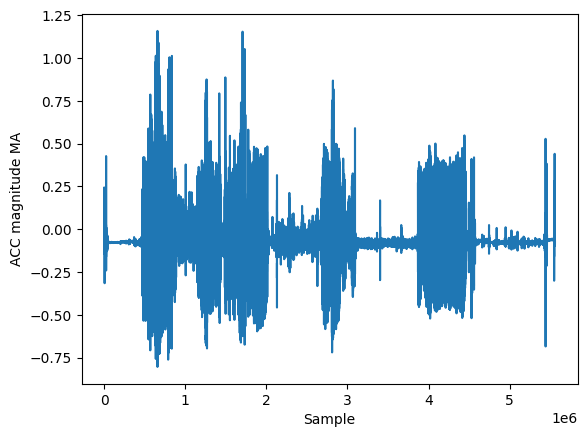

In [32]:
acc = acc_chest_signal
mag = np.linalg.norm(acc, axis=1) - 1
mag_ma = pd.Series(mag).rolling(100).mean().dropna().reset_index(drop=True)

plt.figure()
plt.plot(mag_ma.index, mag_ma.values)
plt.xlabel('Sample')
plt.ylabel('ACC magnitude MA')
plt.show()

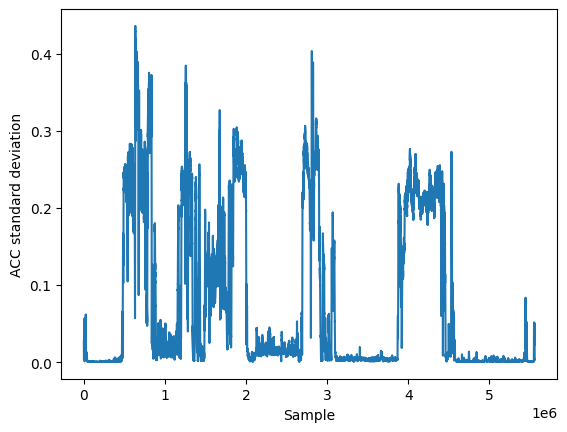

In [33]:
n = 3500
mad_series = mag_ma[:].rolling(window=n).apply(
    lambda x: np.mean(np.abs(x - x.mean())),
    raw=True
).dropna()

plt.figure()
plt.plot(mad_series.index, mad_series.values)
plt.xlabel('Sample')
plt.ylabel('ACC standard deviation')
plt.show()

In [34]:
acc_chest_final = np.array(mad_series)

WRIST acc 

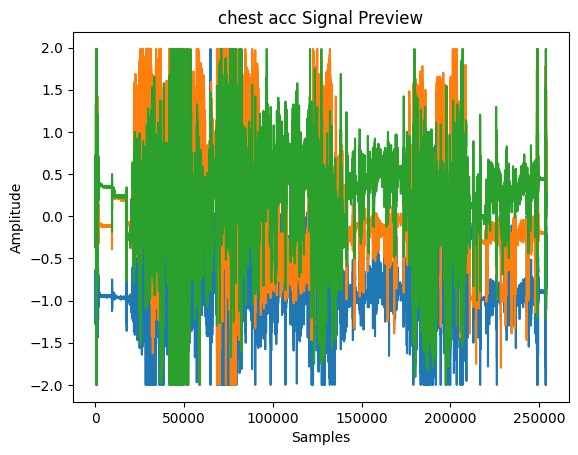

In [35]:
plt.plot(acc_wrist_signal[:]) 
plt.title('chest acc Signal Preview')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

for wrist acc : eucl nom , moving average , and zero out the negative values 

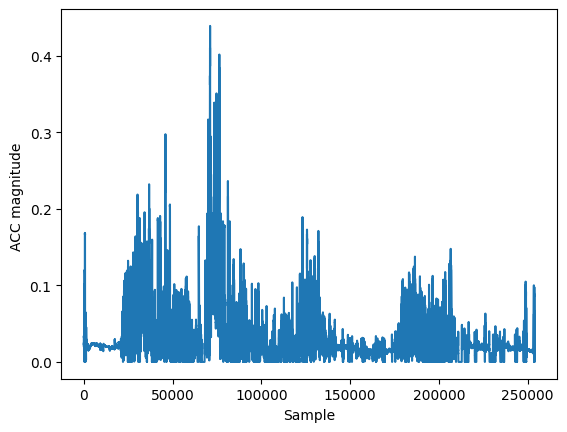

In [36]:
acc = acc_wrist_signal
mag = np.linalg.norm(acc, axis=1) -1
mag_ma = pd.Series(mag).rolling(100).mean().dropna().reset_index(drop=True)
mag_ma = np.array(mag_ma)
mag_ma[mag_ma < 0] = 0

plt.figure()
plt.plot(mag_ma[:])
plt.xlabel('Sample')
plt.ylabel('ACC magnitude ')
plt.show()

In [37]:
acc_wrist_final = mag_ma